## Forecasting Energy Output with FB Prophet

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import mean_absolute_error, mean_squared_error
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [2]:
df = pd.read_csv('../data/interim/filled_for_forecasting.csv', index_col = 0, parse_dates = True)

In [3]:
df.columns

Index(['Shark Meter, KWtotal Kilowatts', 'AE 500kW 1, AC Power Kilowatts',
       'AE 500kW 2, AC Power Kilowatts',
       '(Offline) Weather Station - POA (POA)* Watts/meter²',
       'RECx31 Weather Station, Module Temp Degrees Celsius',
       'RECx31 Weather Station, Ambient Temp Degrees Celsius',
       'AE 500kW 1, PV current Amps', 'AE 500kW 2, PV current Amps',
       'AE 500kW 1, PV voltage Volts', 'AE 500kW 2, PV voltage Volts'],
      dtype='object')

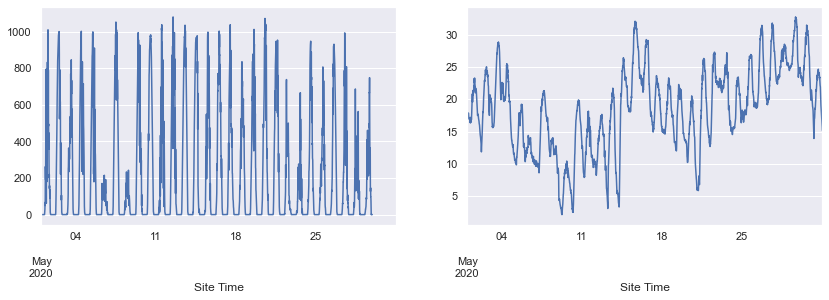

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
_ = plt.subplot(1,2,1)
df['(Offline) Weather Station - POA (POA)* Watts/meter²'].loc['2020-05'].plot();
_ = plt.subplot(1,2,2)
df['RECx31 Weather Station, Ambient Temp Degrees Celsius'].loc['2020-05'].plot();

This is our filled energy output.  One thing we'd like to do is see if we can forecast in 15-minute intervals since it seems that our H-W models and our Sarima models do not do that well.  Let's just take a two week slice of the data and see how Prophet does.  

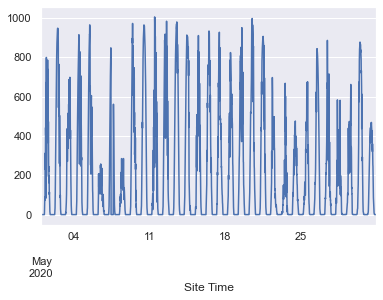

In [4]:
df['Shark Meter, KWtotal Kilowatts'].loc['2020-05'].plot();

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


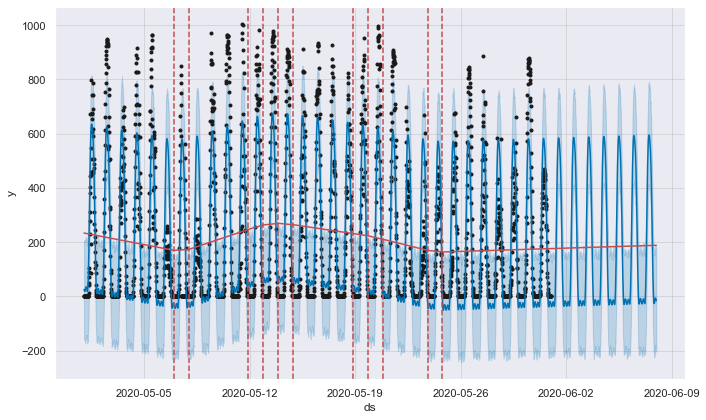

In [7]:
# Our dataframe must have columns 'ds' and 'y'
power_May2020 = df.loc['2020-05'].copy()
power_May2020['y'] = power_May2020['Shark Meter, KWtotal Kilowatts']
power_May2020['ds'] = power_May2020.index

prophet = Prophet(daily_seasonality = True, weekly_seasonality=False)
prophet.fit(power_May2020)
future = prophet.make_future_dataframe(periods=4*24*7, freq='15T')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

The original data is the black dots, the forecast line is in blue, and the confidence levels are in light blue.  We can see that Prophet is doing quite well with this forecast.  Much better than H-W or SARIMA.  Note that sometimes it does predict negative energy output but we are unable to configure a minimum.  

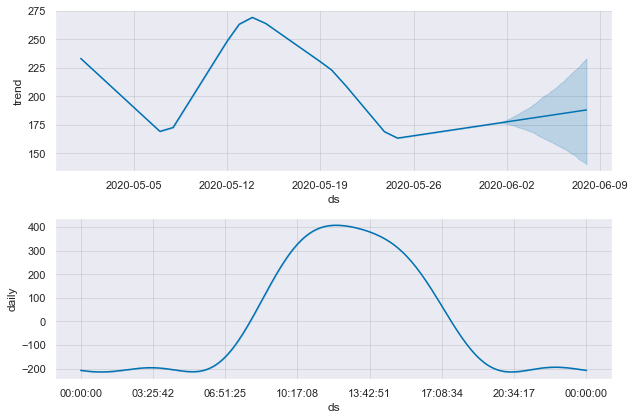

In [8]:
fig2 = prophet.plot_components(forecast)

Since we have data for our forecasted period, we can calculate our errors on test data for this model.  

In [9]:
print('RMSE:', np.sqrt(mean_squared_error(df['Shark Meter, KWtotal Kilowatts'].loc['2020-06-01':'2020-06-07'], \
                                          forecast['yhat'].iloc[-672:])))
print('MSE:', mean_absolute_error(df['Shark Meter, KWtotal Kilowatts'].loc['2020-06-01':'2020-06-07'], \
                                          forecast['yhat'].iloc[-672:]))

RMSE: 131.26637946658306
MSE: 84.90551159943914


Let's try modeling entire time period and forecasting one year into the future just for kicks.  

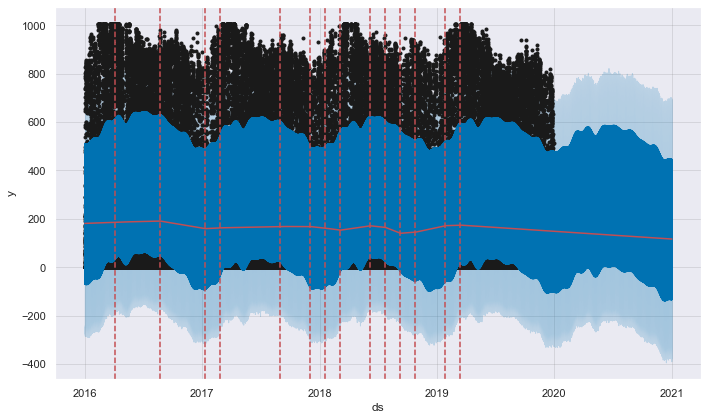

In [16]:
# Our dataframe must have columns 'ds' and 'y'
power = df.loc['2016':'2019'].copy()
power['y'] = power['Shark Meter, KWtotal Kilowatts']
power['ds'] = power.index

prophet = Prophet(daily_seasonality = True, yearly_seasonality=True, weekly_seasonality=False)
prophet.fit(power)
future = prophet.make_future_dataframe(periods=4*24*366, freq='15T')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

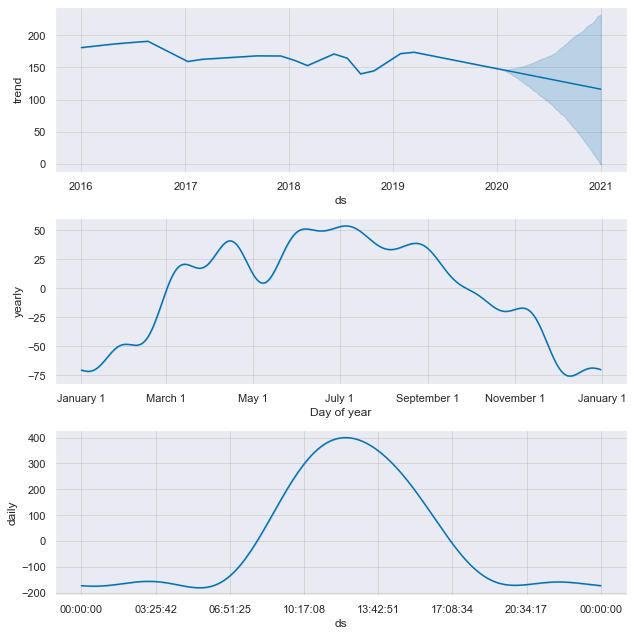

In [17]:
fig2 = prophet.plot_components(forecast)

In [19]:
print('RMSE:', np.sqrt(mean_squared_error(df['Shark Meter, KWtotal Kilowatts'].loc['2020'], \
                                          forecast['yhat'].iloc[-4*24*366:])))
print('MSE:', mean_absolute_error(df['Shark Meter, KWtotal Kilowatts'].loc['2020'], \
                                          forecast['yhat'].iloc[-4*24*366:]))

RMSE: 156.40327006953459
MSE: 106.8079137596598


Let's get prediction of the trend.  To that end, let's look at energy, and we're going to resample to a daily frequency and then predict a trend over the next six years.  

In [20]:
# First we need to get hourly energy in KWH
energy_hourly = df[['Shark Meter, KWtotal Kilowatts']].resample('H').sum()*.25
energy_hourly.columns=['Shark Meter, KWH']

# Then we need to get daily energy in KHW
energy_daily = energy_hourly.resample('D').sum()

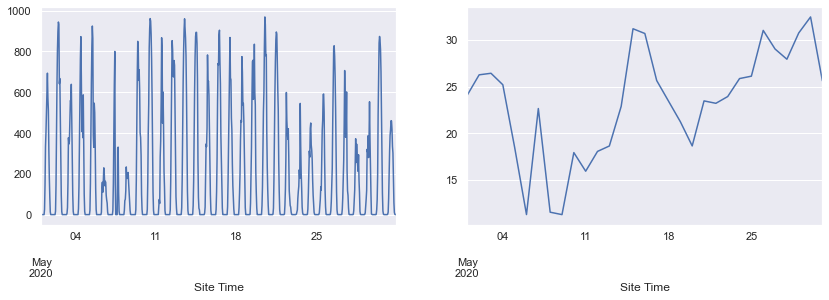

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
_ = plt.subplot(1,2,1)
energy_hourly['Shark Meter, KWH'].loc['2020-05'].plot();
_ = plt.subplot(1,2,2)
df['RECx31 Weather Station, Module Temp Degrees Celsius'].resample('D').mean().loc['2020-05'].plot();

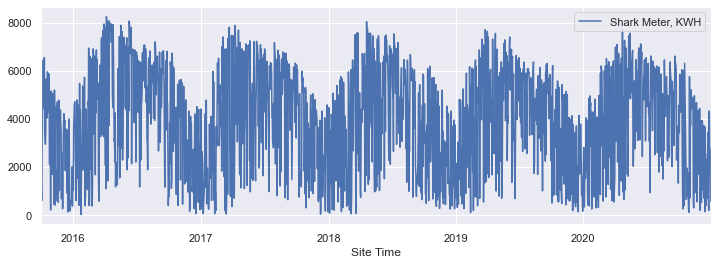

In [21]:
energy_daily.plot(figsize=(12,4));

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


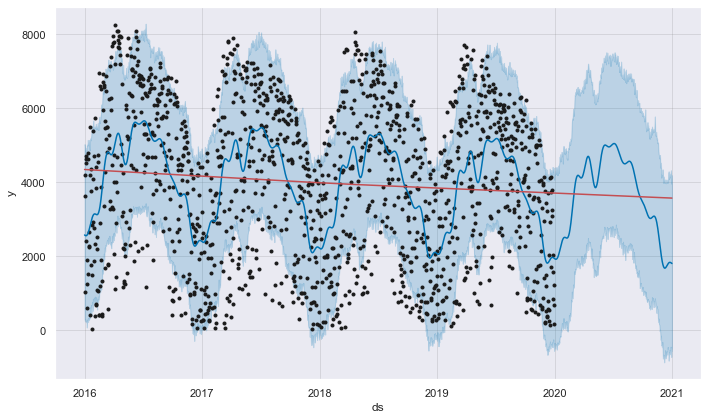

In [31]:
# Our dataframe must have columns 'ds' and 'y'
energy_df = energy_daily.loc['2016':'2019'].copy()
energy_df['y'] = energy_df['Shark Meter, KWH']
energy_df['ds'] = energy_df.index

prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False)
prophet.fit(energy_df)
future = prophet.make_future_dataframe(periods=366, freq='D')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

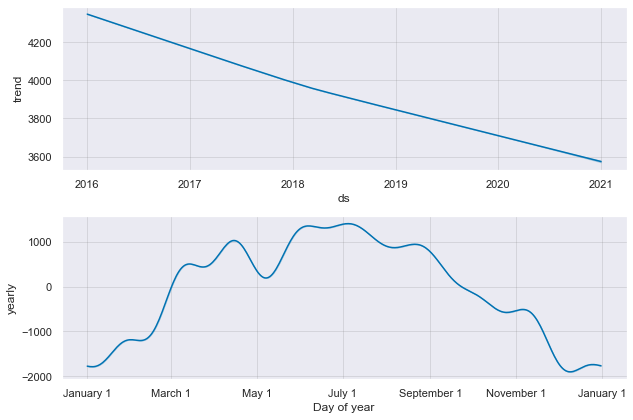

In [32]:
fig2 = prophet.plot_components(forecast)
plt.show()

This shows a pretty strong downward trend in energy production.  

In [33]:
print('RMSE:', np.sqrt(mean_squared_error(energy_daily['Shark Meter, KWH'].loc['2020'], \
                                            forecast['yhat'].iloc[-366:])))
print('MSE:', mean_absolute_error(energy_daily['Shark Meter, KWH'].loc['2020'], \
                                          forecast['yhat'].iloc[-366:]))

RMSE: 1750.1917302065092
MSE: 1506.4910950025126


### Add Cross-validation - not complete yet

In [ ]:
# # Our dataframe must have columns 'ds' and 'y'
# energy_df = energy_daily.loc['2016':'2019'].copy()
# energy_df['y'] = energy_df['Shark Meter, KWH']
# energy_df['ds'] = energy_df.index

# prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False)
# df_cv = cross_validation(prophet, initial='730 days', period='180 days', horizon = '365 days')

# prophet.fit(energy_df)
# future = prophet.make_future_dataframe(periods=366, freq='D')
# forecast = prophet.predict(future)
# fig = prophet.plot(forecast)
# a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

### Attempt to forecast Difference between Inverters 

In [38]:
# First we need to get hourly energy in KWH
inverters_hourly = df[['AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts']].resample('H').sum()*.25
inverters_hourly.columns=['AE 500kW 1, KWH','AE 500kW 2, KWH']

# Then we need to get daily energy in KHW
inverters_daily = inverters_hourly.resample('D').sum()

# Now calculate the difference
inverters_diff = pd.DataFrame(inverters_daily['AE 500kW 1, KWH'] - inverters_daily['AE 500kW 2, KWH'],columns=['Difference'])

# Get max ambient and module temps
inverters_diff['Max Module Temp'] = df['RECx31 Weather Station, Module Temp Degrees Celsius'].resample('D').max()
inverters_diff['Max Ambient Temp'] = df['RECx31 Weather Station, Ambient Temp Degrees Celsius'].resample('D').max()
               

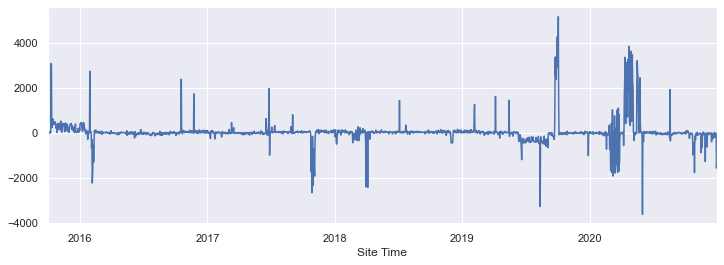

In [39]:
inverters_diff['Difference'].plot(figsize=(12,4));

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


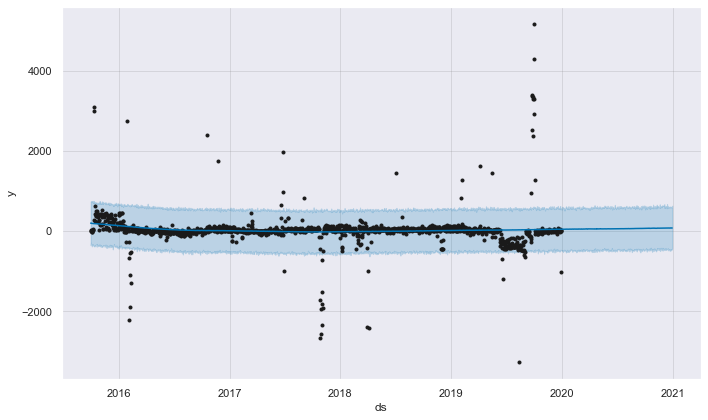

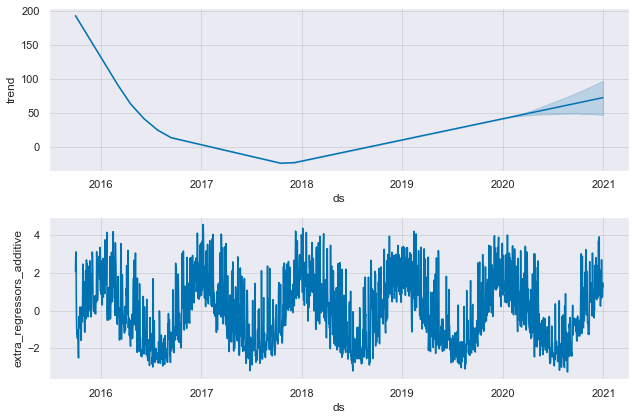

In [41]:
inverters_diff['y'] = inverters_diff['Difference']
inverters_diff['ds'] = inverters_diff.index

prophet = Prophet(weekly_seasonality=False, yearly_seasonality=False)
prophet.add_regressor('Max Module Temp')
prophet.add_regressor('Max Ambient Temp')
prophet.fit(inverters_diff.loc[:'2019'])
future = prophet.make_future_dataframe(periods=365, freq='D')
future.set_index('ds',inplace=True)
future['Max Module Temp'] = inverters_diff['Max Module Temp']
future['Max Ambient Temp'] = inverters_diff['Max Ambient Temp']
future.reset_index(inplace=True)
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
fig2 = prophet.plot_components(forecast)